# Defacing pre-registration - Statistical analysis in R

## Function to simulate data with missing values

In [17]:
source("simulate_data.R")

Simulate normally-distributed ratings

In [18]:
n_sub <- 580 #nbr of subjects available in the dataset
n_rated <- 130
n_rater <- 4 #nbr of raters
mean <- 20
sd <- 10
#Define for each rater the percentage of biased ratings
perc_biased <- c(20,40,50,60)
bias <- 10

df <- simulate_normal_data(n_rated, n_sub, n_rater, perc_biased, mean=mean, sd=sd, bias=bias)
df$ratings <- as.numeric(df$ratings)
df

sub,defaced,rater,ratings
<int>,<fct>,<fct>,<dbl>
1,original,rater01,26
1,defaced,rater01,26
2,original,rater01,14
2,defaced,rater01,14
3,original,rater01,11
3,defaced,rater01,11
4,original,rater01,27
4,defaced,rater01,27
5,original,rater01,34


## repeated-measure ANOVA

### Check assumptions

repeated-measure ANOVA makes the following three assumptions on the data :
1. **No significant outlier** : By construction the ratings cannot leave the range we define, so this assumption is granted
2. **Normality** : we will have many ratings so by the central theorem this assumption should be ok
3. **Sphericity** : the variance of the differences between groups should be equal.

In [19]:
##Test for normality
library(ggpubr)
shapiro.test(df$ratings)


	Shapiro-Wilk normality test

data:  df$ratings
W = 0.99535, p-value = 0.002917


If the data is normally distributed, p-values should be greater than 0.05

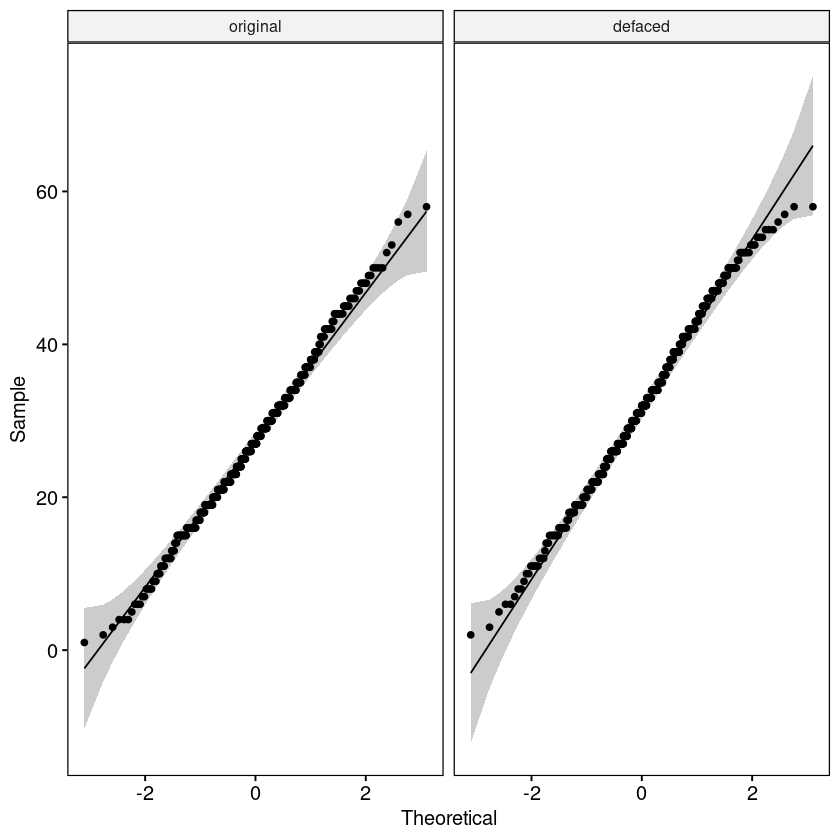

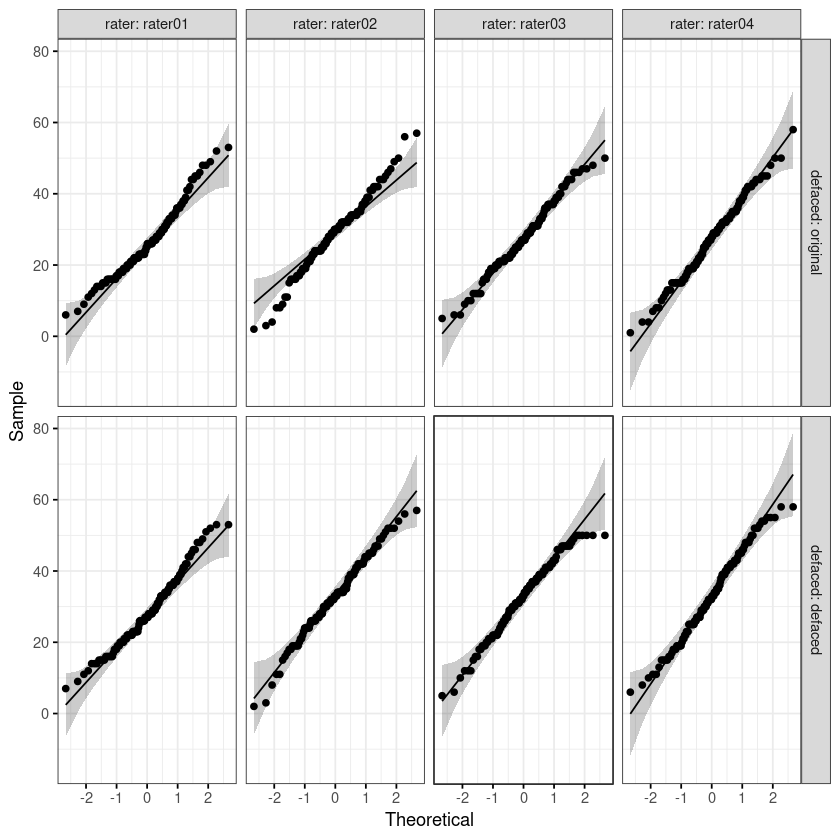

In [20]:
## Other test for normality
ggqqplot(df, "ratings", facet.by = 'defaced')
ggqqplot(df, "ratings", ggtheme = theme_bw()) +
  facet_grid(defaced ~ rater, labeller = "label_both")

We can assume normality if the points fall along the reference line.

In [21]:
## Test for sphericity
library(rstatix)
suppressWarnings(anova_test(data = df, dv = ratings, wid= sub, within = c(defaced, rater)))

ANOVA Table (type III tests)

$ANOVA
         Effect DFn DFd       F        p p<.05   ges
1       defaced   1 129 384.195 1.69e-40     * 0.038
2         rater   3 387   3.408 1.80e-02     * 0.018
3 defaced:rater   3 387  16.244 5.79e-10     * 0.005

$`Mauchly's Test for Sphericity`
         Effect     W     p p<.05
1         rater 0.972 0.606      
2 defaced:rater 0.920 0.059      

$`Sphericity Corrections`
         Effect   GGe       DF[GG]    p[GG] p[GG]<.05   HFe       DF[HF]
1         rater 0.981 2.94, 379.63 1.80e-02         * 1.006 3.02, 389.46
2 defaced:rater 0.948    2.84, 367 1.46e-09         * 0.972 2.92, 376.14
     p[HF] p[HF]<.05
1 1.80e-02         *
2 9.55e-10         *

For the assumption of sphericity to be verified, the test should not reject the null hypothesis, which is that the variance between group is equal. The assumption is violated by the interaction defaced:rater, thus anova_test can apply automatically sphericity correction

### Run ANOVA

In [22]:
suppressWarnings(res.aov <- anova_test(data = df, dv = ratings, wid = sub, within = c(defaced, rater)))
get_anova_table(res.aov)

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,defaced,1,129,384.195,1.69e-40,*,0.038
2,rater,3,387,3.408,1.80e-02,*,0.018
3,defaced:rater,3,387,16.244,5.79e-10,*,0.005


### Verify that the null hypothesis is not rejected if no bias has been introduced

In [23]:
#Define for each rater the percentage of biased ratings
perc_biased <- c(10,10,10,10)
bias <- 1

df_nobias <- simulate_normal_data(n_rated, n_sub, n_rater, perc_biased, mean=mean, sd=sd, bias=bias)
df_nobias$ratings <- as.numeric(df_nobias$ratings)

## Lmer should not find significant result
suppressWarnings(res.aov <- anova_test(data = df_nobias, dv = ratings, wid = sub, within = c(defaced, rater)))
get_anova_table(res.aov)

,Effect,DFn,DFd,F,p,p<.05,ges
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
1,defaced,1,129,5.2406e+01,3.61e-11,*,2.44e-05
2,rater,3,387,1.4150e+00,2.38e-01,,9.00e-03
3,defaced:rater,3,387,3.1100e-26,1.00e+00,,3.86e-32


## Friedman test

Non-parametric alternative to repeated-measure ANOVA.

In [24]:
friedman.test(y=df$ratings, groups=factor(df$defaced), blocks=factor(df$sub))

ERROR: Error in friedman.test.default(y = df$ratings, groups = factor(df$defaced), : not an unreplicated complete block design


Cannot use this function : An unreplicated complete block design has exactly 1 observation for each combination of the two grouping factors. But we have 4 observations of the combination defaced + sub 1 : rater01,02,03,04.